# Estimating consumption spending US

### Data used:
Consumption spending, nominal = FRED/DHCERC1Q027SBEA
Consumption deflator = FRED/CONSDEF
Interest rate/discount rate = FRED/INTDSRUSM193N
Unemployment rate = FRED/UNRATE

### Limitations

This model doesn't include household income as that's being calculated elsewhere, and can be added in later.

So the results of the model, aren't tooooooo insightful.

In [39]:
# Imports needed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [40]:
# read data from CSV
data = pd.read_csv('consumption_data.csv', header=0)
data = data[::-1]

In [46]:
"""
We need to convert consumption into Constant 2005 US$ dollars
Calculate the change in const_consumption to aid in making the data stationary for regression purposes
Drop NAs created from calculating change.
"""

data = data.assign(const_consumption = lambda x: (x['consumption'] / (x['deflator'] / 100)))
data = data.assign(change = pd.rolling_apply(data['const_consumption'], 2, lambda x: x[0] - x[1]))
data = data.dropna()

In [48]:
data.head()

,date,consumption,deflator,interestRate,unemployment,const_consumption,change
222,1/04/1959,138.5,14.591905,2.92,5.2,949.156399,-18.879582
221,1/07/1959,141.6,14.683027,3.50,5.5,964.378803,-15.222404
220,1/10/1959,144.6,14.756015,3.83,6.3,979.939367,-15.560564
219,1/01/1960,146.5,14.835452,4.00,6.8,987.499403,-7.560036
218,1/04/1960,149.1,14.866673,4.00,7.0,1002.914371,-15.414967


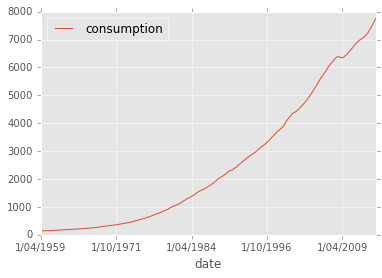

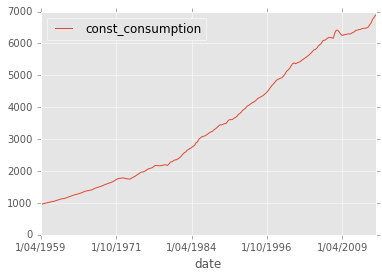

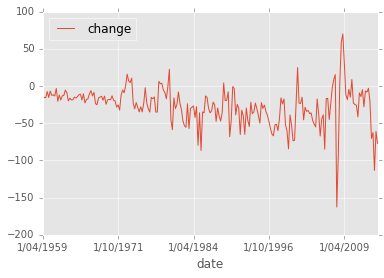

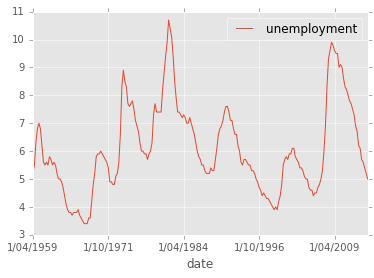

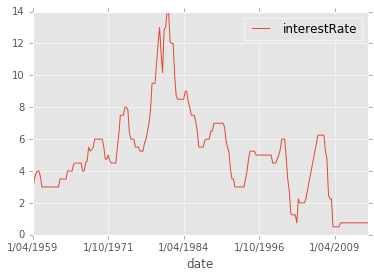

In [49]:
data.plot(x='date', y='consumption')
data.plot(x='date', y='const_consumption')
data.plot(x='date', y='change')
data.plot(x='date', y='unemployment')
data.plot(x='date', y='interestRate')

Change in consumption plotted with interest rates
Constant consumption plotted with interest rates
Consumption plotted with unemployment
Constant consumption plotted with enemployment


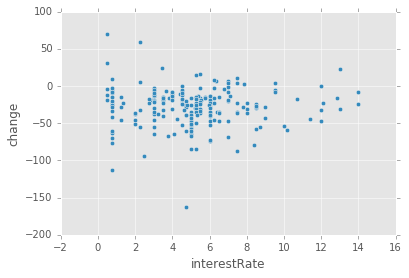

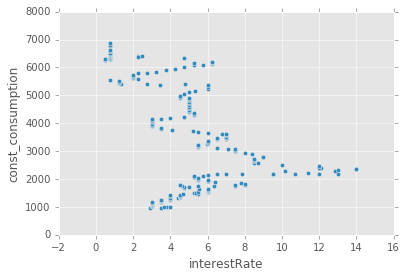

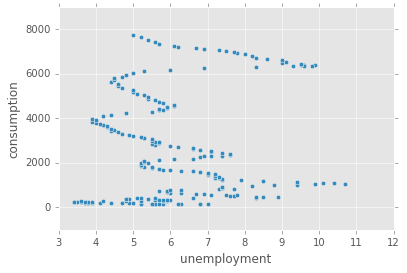

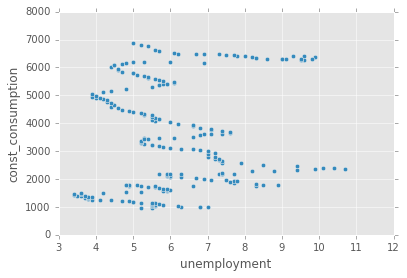

In [58]:
# Explores variables against consumption using scatter plots

# Consumption plotted with Interest Rates
print "Change in consumption plotted with interest rates"
data.plot(x='interestRate', y='change', kind='scatter')

print "Constant consumption plotted with interest rates"
data.plot(x='interestRate', y='const_consumption', kind='scatter')
                   
# Consumption plotted with unemployment
print "Consumption plotted with unemployment"
data.plot(x='unemployment', y='consumption', kind='scatter')
                   
print "Constant consumption plotted with enemployment"
data.plot(x='unemployment', y='const_consumption', kind='scatter')

## Correlation Tables

In [59]:
data.corr()

,consumption,deflator,interestRate,unemployment,const_consumption,change
consumption,1.000000,0.972239,-0.518108,0.156077,0.983658,-0.212561
deflator,0.972239,1.000000,-0.385072,0.203957,0.991528,-0.266741
interestRate,-0.518108,-0.385072,1.000000,0.248269,-0.444359,-0.020305
unemployment,0.156077,0.203957,0.248269,1.000000,0.139438,0.127417
const_consumption,0.983658,0.991528,-0.444359,0.139438,1.000000,-0.260638
change,-0.212561,-0.266741,-0.020305,0.127417,-0.260638,1.000000


# Regressions on data

## K-nearest neighbours
This first regression, gets inputs and outputs the estimated consumption value in $. It only predicts a stationary point, and doesn't estimate the change in consumption over time.

In [60]:
from sklearn.neighbors import KNeighborsRegressor

x = np.array(data['interestRate'])
x_neigh = x.reshape(len(x), 1)
y = np.array(data['change'])
y_neigh = y.reshape(len(y), 1)

neigh = KNeighborsRegressor(n_neighbors=1)
neigh.fit(x_neigh, y_neigh)
neigh.get_params()

prediction1 = neigh.predict(1.5)
prediction2 = neigh.predict(9)
print "With an interest rate of 1.5 percent, consumption is predicted to be %s." %str(prediction1)
print "With an interest rate of 9 percent, consumption is predicted to be %s." %str(prediction2)

With an interest rate of 1.5 percent, consumption is predicted to be [[-23.39870328]].
With an interest rate of 9 percent, consumption is predicted to be [[-42.34221452]].


## Linear regressions
Uses a simple and then multivariable linear regression. These results aren't terribly helpful as the data is missing income levels.

### Simple linear regression

In [62]:
# Simple linear regression, exploring effect of interest rates on consumption spending
# change = intercept + slope(interest rates) + std_err

from statsmodels.formula.api import ols

simple_model = ols('change ~ interestRate', data).fit()
print simple_model.summary()

                            OLS Regression Results                            
Dep. Variable:                 change   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                   0.09115
Date:                Mon, 30 Jan 2017   Prob (F-statistic):              0.763
Time:                        22:57:26   Log-Likelihood:                -1036.7
No. Observations:                 223   AIC:                             2077.
Df Residuals:                     221   BIC:                             2084.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept      -25.8115      3.481     -7.416   

### Multiple linear regression

$$ \Delta c = a + \beta_1 * interestRate + \beta_2 * unemployment $$

In [63]:
# multiple regression
# consumption = intercept + b(const_consumption) + c(unemployment) + stderr

model = ols('change ~ interestRate + unemployment', data).fit()
print model.summary()

                            OLS Regression Results                            
Dep. Variable:                 change   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     2.143
Date:                Mon, 30 Jan 2017   Prob (F-statistic):              0.120
Time:                        22:57:28   Log-Likelihood:                -1034.6
No. Observations:                 223   AIC:                             2075.
Df Residuals:                     220   BIC:                             2085.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept      -37.9685      6.869     -5.527   